# Environment

In [ ]:
# Install libraries
!pip install geopandas
!pip install rasterio

# Load libraries
%matplotlib inline
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import geopandas as gpd
import pylab as py
import statistics
from scipy.stats import yeojohnson, pearsonr
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cross_decomposition import CCA

import sklearn
assert sklearn.__version__ >= "0.20"

import tensorflow as tf
assert tf.__version__>= "2.0"

import sys
assert sys.version_info >= (3,5)

import os

In [ ]:
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get all the rows as output
pd.set_option('display.max_columns', 190)
pd.set_option('display.max_rows', 160)

In [ ]:
conda install -c conda-forge rasterio

### Change and Transition Matrices

In [ ]:
import rasterio

# FUNCTION: read .tif
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform

# FUNCTION: calculate change matrix
def calculate_change_matrix(before, after):
    unique_before = np.unique(before)
    unique_after = np.unique(after)
    all_classes = np.unique(np.concatenate((unique_before, unique_after)))

    change_matrix = pd.DataFrame(0, index=all_classes, columns=all_classes)

    for i in range(before.shape[0]):
        for j in range(before.shape[1]):
            from_class = before[i, j]
            to_class = after[i, j]
            change_matrix.loc[from_class, to_class] += 1

    return change_matrix

# FUNCTION: calculate transition matrix
def calculate_transition_probabilities(change_matrix):
    transition_matrix = change_matrix.div(change_matrix.sum(axis=1), axis=0)
    return transition_matrix

# FUNCTION: make it round
def main(before_file, after_file):
    # read input
    before, _ = read_raster(before_file)
    after, _ = read_raster(after_file)

    # change matrix
    change_matrix = calculate_change_matrix(before, after)
    print("change matrix:")
    print(change_matrix)

    # transition matrix
    transition_matrix = calculate_transition_probabilities(change_matrix)
    print("transition matrix:")
    print(transition_matrix)

    return change_matrix, transition_matrix

before_file = 'D:\\AML\\datasets\\rc_1992.tif'
after_file = 'D:\\AML\\datasets\\rc_1996.tif'
change_matrix, transition_matrix = main(before_file, after_file)

change matrix:
          0       1        2        3        4      5        6      7
0  16340475       0        0        0        0      0        0      0
1         0  264134       24      443       61    158        0      6
2         0    1494  2099063      382     4621    652     2877     45
3         0    9992    14524  8616351     1477    129       26  20966
4         0     229      742      368  1581739    154      165     63
5         0       0        0        0        0  18206        0      0
6         0     290     3267        0     1337    279  1051882      0
7         0       2       17      202        2     31        0  64735
transition matrix:
     0         1         2         3         4         5         6         7
0  1.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1  0.0  0.997387  0.000091  0.001673  0.000230  0.000597  0.000000  0.000023
2  0.0  0.000708  0.995225  0.000181  0.002191  0.000309  0.001364  0.000021
3  0.0  0.001153  0.001676  

### Transformation/Prediction

In [ ]:
from rasterio.transform import from_origin

current_land_use_map = 'D:\\AML\\datasets\\rc_1997.tif'
data_directory = "D:\\AML\\output\\validation"

# current land use map
with rasterio.open(current_land_use_map) as src:
    current_land_use_map = src.read(1)
    transform = src.transform  # spatial transform

# define transition probs
transition_probs = transition_matrix

# probability validity (between 0 and 1 and sum to 1 for each row)
if (transition_probs < 0).any() or (transition_probs > 1).any() or not np.allclose(transition_probs.sum(axis=1), 1):
    raise ValueError("Invalid transition probabilities.")

# FUNCTION: apply the transition by transition probs
def apply_transition(land_use, transition_probs):
    new_land_use = np.copy(land_use)
    rows, cols = land_use.shape
    for row in range(rows):
        for col in range(cols):
            current_category = int(land_use[row, col])
            if 1 <= current_category <= 5:
                transition_probs_normalized = transition_probs[current_category - 1]
                new_category = np.argmax(np.random.multinomial(1, transition_probs_normalized))
                new_land_use[row, col] = new_category + 1
    return new_land_use

# apply transition to current land use map
predicted_land_use = apply_transition(current_land_use_map, transition_probs)

# shape of predicted land use map for saving
rows, cols = predicted_land_use.shape

# save predicted land use map as .tif
output_raster_path = os.path.join(data_directory, 'predicted_land_use_1997.tif')
with rasterio.open(output_raster_path, 'w', driver='GTiff', width=cols, height=rows, count=1, dtype=rasterio.int32, crs=src.crs, transform=transform) as dst:
    dst.write(predicted_land_use, 1)

print("Prediction completed. The result is saved to:", output_raster_path)


# Validierung

In [ ]:
import geopandas as gpd
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, cohen_kappa_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class Validation:
    """
    A class to validate spatial prediction data against ground truth data.

    Attributes:
    ----------
    truth_path : str
        The file path to the ground truth data.
    predicted_path : str
        The file path to the predicted data.
    truth_label_col : str, optional
        The column name of the ground truth labels (default is 'grid_code').
    predicted_label_col : str, optional
        The column name of the predicted labels (default is 'grid_code').
    truth_data : GeoDataFrame
        The loaded ground truth data.
    predicted_data : GeoDataFrame
        The loaded predicted data.
    merged_data : DataFrame
        The merged data containing both ground truth and predicted labels.
    metrics : dict
        A dictionary to store calculated metrics.
    """

    def __init__(self, truth_path: str, predicted_path: str, truth_label_col: str = 'grid_code', predicted_label_col: str = 'grid_code'):
        self.truth_path = truth_path
        self.predicted_path = predicted_path
        self.truth_label_col = truth_label_col
        self.predicted_label_col = predicted_label_col
        self.truth_data = None
        self.predicted_data = None
        self.merged_data = None
        self.metrics = {}

    def load_data(self) -> None:
        """Loads the ground truth and predicted data from the given file paths."""
        try:
            logging.info("Loading ground truth data from %s", self.truth_path)
            self.truth_data = gpd.read_file(self.truth_path)
            logging.info("Loading predicted data from %s", self.predicted_path)
            self.predicted_data = gpd.read_file(self.predicted_path)
        except Exception as e:
            logging.error("Error loading data: %s", e)
            raise ValueError(f"Error loading data: {e}")

    def preprocess_data(self) -> None:
        """Preprocesses the data by rounding coordinates and creating unique identifiers."""
        logging.info("Preprocessing data")
        self.truth_data['rounded_x'] = self.truth_data.geometry.x.round(6)
        self.truth_data['rounded_y'] = self.truth_data.geometry.y.round(6)
        self.predicted_data['rounded_x'] = self.predicted_data.geometry.x.round(6)
        self.predicted_data['rounded_y'] = self.predicted_data.geometry.y.round(6)

        self.truth_data['unique_id'] = self.truth_data.geometry.apply(lambda geom: f'{geom.x:.6f}_{geom.y:.6f}')
        self.predicted_data['unique_id'] = self.predicted_data.geometry.apply(lambda geom: f'{geom.x:.6f}_{geom.y:.6f}')

    def merge_data(self) -> None:
        """Merges the ground truth and predicted data on unique identifiers."""
        logging.info("Merging ground truth and predicted data")
        self.merged_data = self.truth_data.merge(self.predicted_data, on='unique_id', how='inner')

        if len(self.truth_data) != len(self.predicted_data):
            logging.warning("The number of points in truth and predicted datasets is not the same.")

        if len(self.merged_data) == 0:
            logging.error("There are no common points between the truth and predicted datasets.")
            raise ValueError("Error: There are no common points between the truth and predicted datasets.")

    def plot_data(self) -> None:
        """Plots the ground truth and predicted data on a map."""
        logging.info("Plotting data")
        ax = self.truth_data.plot(color='blue', label='Truth Data')
        self.predicted_data.plot(ax=ax, color='red', label='Predicted Data')
        plt.legend()
        plt.title('Truth vs Predicted Data')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()

    def calculate_metrics(self) -> None:
        """Calculates various validation metrics comparing ground truth and predicted labels."""
        logging.info("Calculating metrics")
        truth_labels = self.merged_data[f'{self.truth_label_col}_x'].astype(int)
        predicted_labels = self.merged_data[f'{self.predicted_label_col}_y'].astype(int)

        self.metrics['Accuracy'] = accuracy_score(truth_labels, predicted_labels)
        self.metrics['MAE'] = mean_absolute_error(truth_labels, predicted_labels)
        self.metrics['RMSE'] = mean_squared_error(truth_labels, predicted_labels, squared=False)
        self.metrics['Cohen\'s Kappa'] = cohen_kappa_score(truth_labels, predicted_labels)
        self.metrics['Confusion Matrix'] = confusion_matrix(truth_labels, predicted_labels)
        self.metrics['Classification Report'] = classification_report(truth_labels, predicted_labels, output_dict=True)

    def display_metrics(self) -> None:
        """Displays the calculated validation metrics."""
        logging.info("Displaying metrics")
        df_metrics = pd.DataFrame(self.metrics['Classification Report']).transpose()
        df_metrics['Accuracy'] = self.metrics['Accuracy']
        df_metrics['MAE'] = self.metrics['MAE']
        df_metrics['RMSE'] = self.metrics['RMSE']
        df_metrics['Cohen\'s Kappa'] = self.metrics['Cohen\'s Kappa']
        df_confusion = pd.DataFrame(self.metrics['Confusion Matrix'])

        print("\nAccuracy, MAE, RMSE, Cohen's Kappa:\n", df_metrics)
        print("\nConfusion Matrix:\n", df_confusion)

    def validate(self) -> None:
        """Runs the complete validation process: loading data, preprocessing, merging, plotting, and calculating metrics."""
        logging.info("Starting validation process")
        self.load_data()
        self.preprocess_data()
        self.merge_data()
        self.plot_data()
        self.calculate_metrics()
        self.display_metrics()
        logging.info("Validation process completed")

# Example
truth_path = "/content/drive/MyDrive/AML_group_project/AML_project/datasets/final_project/validation/validation_cut/export_original_1997_PairwiseClip.shp"
predicted_path = "/content/drive/MyDrive/AML_group_project/AML_project/datasets/final_project/validation/validation_cut/export_predicted_1997_PairwiseClip.shp"
validator = Validation(truth_path, predicted_path)
validator.validate()


# Visualisation of Land use Change

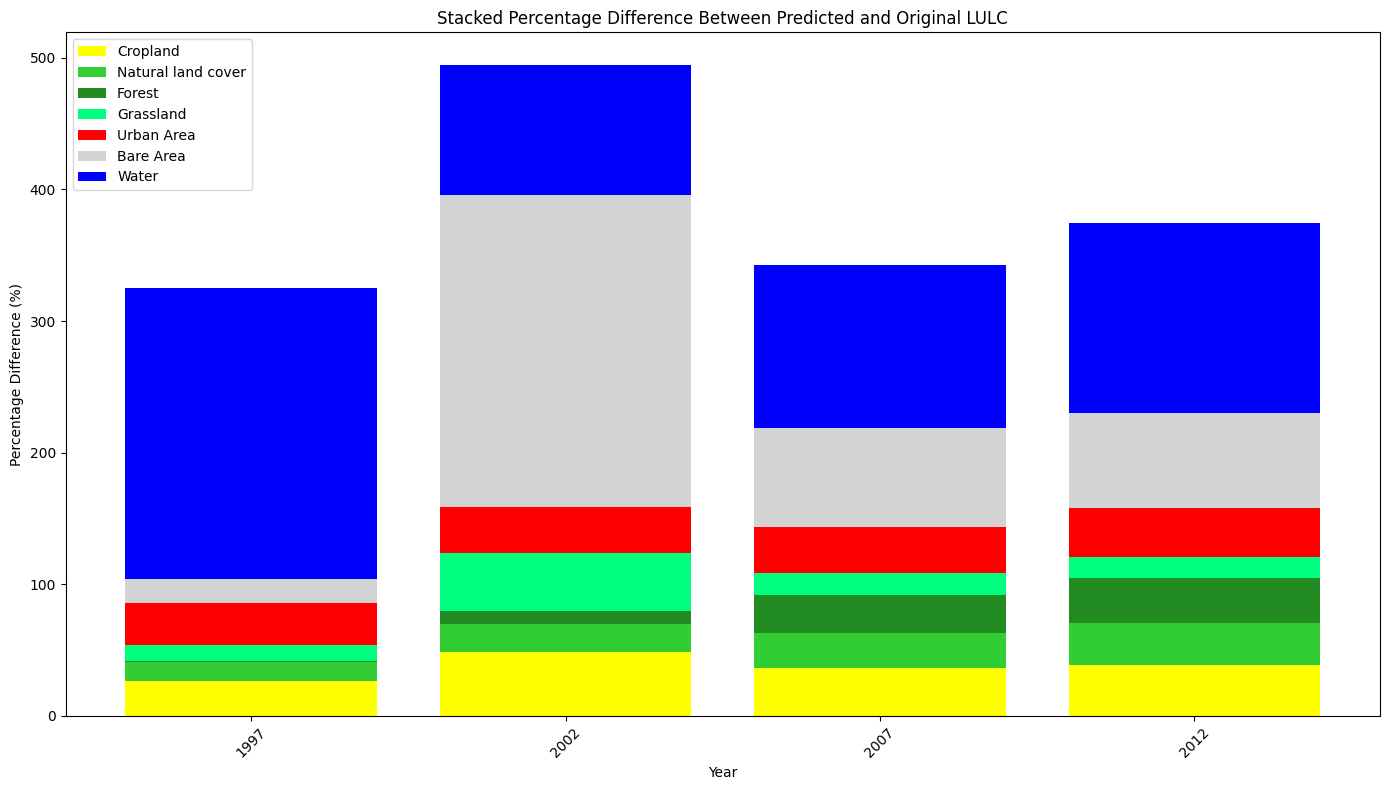

In [13]:
import os
import time
import math
import logging
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Union
from rasterio.plot import show

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

class LandUseMapPlotter:
    def __init__(self, file_paths: List[str], years: List[int], land_use_colors: Dict[int, str], land_use_labels: Dict[int, str], gridcode_column: str = 'gridcode'):
        """
        Initialize the LandUseMapPlotter.

        Parameters:
        - file_paths (List[str]): List of file paths for shapefiles and raster files.
        - years (List[int]): List of years corresponding to the file paths.
        - land_use_colors (Dict[int, str]): Dictionary mapping land use codes to colors.
        - land_use_labels (Dict[int, str]): Dictionary mapping land use codes to labels.
        - gridcode_column (str): Column name for land use codes. Default is 'gridcode'.

        Example:
            file_paths = ['data/land_use_1990.shp', 'data/land_use_2000.shp']
            years = [1990, 2000]
            land_use_colors = {1: "yellow", 2: "green"}
            land_use_labels = {1: "Agriculture", 2: "Forest"}

            plotter = LandUseMapPlotter(file_paths, years, land_use_colors, land_use_labels, gridcode_column='land_code')
        """
        if len(file_paths) != len(years):
            raise ValueError(f"Lengths of file_paths (length: {len(file_paths)}) and years (length: {len(years)}) do not match")
        if len(land_use_colors) != len(land_use_labels):
            raise ValueError("Lengths of land_use_colors and land_use_labels do not match")

        self.file_paths = file_paths
        self.years = years
        self.land_use_colors = land_use_colors
        self.land_use_labels = land_use_labels
        self.gridcode_column = gridcode_column
        self.geodataframes = []
        self.raster_datasets = []
        self.land_use_counts = pd.DataFrame(columns=[land_use_labels[i] for i in land_use_labels.keys()])

        # Sort the years and corresponding file paths
        sorted_data = sorted(zip(self.years, self.file_paths))
        self.years, self.file_paths = zip(*sorted_data)
        self.years = list(self.years)
        self.file_paths = list(self.file_paths)


    def load_files(self) -> None:
        """
        Load shapefiles and raster files based on the provided paths.

        Example:
            plotter.load_files()
        """
        start_time = time.time()
        for path in self.file_paths:
            try:
                if path.endswith('.tif'):
                    self._load_raster_file(path)
                elif path.endswith('.shp'):
                    self._load_shapefile(path, start_time)
                else:
                    logger.warning(f"Unsupported file format for '{path}'")
                    self._append_none()
            except Exception as e:
                logger.error(f"Error loading file '{path}': {e}")
                self._append_none()

        logger.info(f"Total loaded geodataframes: {len([gdf for gdf in self.geodataframes if gdf is not None])}")

    def _load_raster_file(self, path: str) -> None:
        """Load a raster file."""
        try:
            self.raster_datasets.append(rasterio.open(path))
            self.geodataframes.append(None)
        except Exception as e:
            logger.error(f"Failed to load raster file '{path}': {e}")
            self._append_none()

    def _load_shapefile(self, path: str, start_time: float) -> None:
        """Load a shapefile."""
        try:
            load_time = time.time() - start_time
            gdf = gpd.read_file(path)
            if self.gridcode_column not in gdf.columns:
                raise ValueError(f"Column '{self.gridcode_column}' not found in shapefile '{path}'. Please rename the column to '{self.gridcode_column}' in your GIS system.")
            self.geodataframes.append(gdf)
            self.raster_datasets.append(None)
            logger.info(f"Loaded shapefile '{path}' with {len(gdf)} records in {load_time:.2f} seconds.")
        except Exception as e:
            logger.error(f"Failed to load shapefile '{path}': {e}")
            self._append_none()

    def _append_none(self) -> None:
        """Append None to both geodataframes and raster datasets lists."""
        self.raster_datasets.append(None)
        self.geodataframes.append(None)

    def plot_maps(self, figsize: tuple = (15, 10), num_cols: int = 3, save_path: Optional[str] = None, save_format: str = 'png', show_plot: bool = True) -> None:
        """
        Plot land use maps for each year.

        Parameters:
        - figsize (tuple): Figure size for the plot.
        - num_cols (int): Number of columns in the subplot grid.
        - save_path (Optional[str]): Path to save the plot.
        - save_format (str): Format to save the plot ('png', 'jpg', 'pdf', etc.).
        - show_plot (bool): Whether to display the plot.

        Example:
            plotter.plot_maps(save_path='plots/land_use_maps.png', save_format='png', show_plot=False)
        """
        num_files = len(self.file_paths)
        num_rows = math.ceil(num_files / num_cols)

        fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
        axes = axes.flatten()

        for i, (gdf, dataset, year, path) in enumerate(zip(self.geodataframes, self.raster_datasets, self.years, self.file_paths)):
            ax = axes[i]
            title_suffix = "Original" if "original" in path else "Predicted"
            if gdf is not None:
                self.plot_single_map(ax, gdf, year, title_suffix)
            elif dataset is not None:
                self.plot_single_raster(ax, dataset, year, title_suffix)

        if num_files < len(axes):
            self.add_legend(axes[num_files])
            for j in range(num_files + 1, len(axes)):
                fig.delaxes(axes[j])
        else:
            self.add_legend(axes[-1])

        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)

        if save_path:
            try:
                if not os.path.exists(os.path.dirname(save_path)):
                    os.makedirs(os.path.dirname(save_path))
                    logger.info(f"Created directory: {os.path.dirname(save_path)}")

                plt.savefig(save_path, format=save_format)
                logger.info(f"Plot saved successfully to {save_path}")
            except Exception as e:
                logger.error(f"Failed to save plot to {save_path}: {e}")

        if show_plot:
            plt.show()
        else:
            plt.close(fig)

    def plot_single_map(self, ax: plt.Axes, gdf: gpd.GeoDataFrame, year: int, title_suffix: str) -> None:
        """
        Plot a single shapefile map.

        Parameters:
        - ax (plt.Axes): Matplotlib Axes object.
        - gdf (gpd.GeoDataFrame): GeoDataFrame containing the shapefile data.
        - year (int): Year corresponding to the map.
        - title_suffix (str): Suffix to add to the title to distinguish original and predicted maps.

        Example:
            plotter.plot_single_map(ax, gdf, 1990, "Original")
        """
        for land_use_code, color in self.land_use_colors.items():
            gdf[gdf[self.gridcode_column] == land_use_code].plot(ax=ax, color=color)
        ax.set_title(f'Year {year} ({title_suffix})', fontsize=16, fontweight='bold')
        ax.axis('off')

    def plot_single_raster(self, ax: plt.Axes, dataset: rasterio.io.DatasetReader, year: int, title_suffix: str) -> None:
        """
        Plot a single raster map.

        Parameters:
        - ax (plt.Axes): Matplotlib Axes object.
        - dataset (rasterio.io.DatasetReader): Raster dataset.
        - year (int): Year corresponding to the map.
        - title_suffix (str): Suffix to add to the title to distinguish original and predicted maps.

        Example:
            plotter.plot_single_raster(ax, dataset, 2000, "Predicted")
        """
        show((dataset, 1), ax=ax, cmap='viridis', title=f'Year {year} ({title_suffix})')
        ax.axis('off')

    def add_legend(self, ax: plt.Axes) -> None:
        """
        Add a legend to the plot.

        Parameters:
        - ax (plt.Axes): Matplotlib Axes object.

        Example:
            plotter.add_legend(ax)
        """
        legend_patches = []
        for land_use_code, color in self.land_use_colors.items():
            legend_label = self.land_use_labels.get(land_use_code, f'Land Use {land_use_code}')
            patch = plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black')
            legend_patches.append((patch, legend_label))

        ax.legend(*zip(*legend_patches), loc='center', fontsize=12)
        ax.axis('off')

    def count_land_use(self) -> None:
        """
        Count the number of occurrences for each land use category in shapefiles.

        Example:
            plotter.count_land_use()
        """
        counts_list = []
        for gdf, year in zip(self.geodataframes, self.years):
            if gdf is not None:
                if self.gridcode_column not in gdf.columns:
                    logger.warning(f"Column '{self.gridcode_column}' not found in data for year {year}. Skipping...")
                    continue
                category_counts = {self.land_use_labels[i]: (gdf[self.gridcode_column] == i).sum() for i in self.land_use_labels.keys()}
                counts_list.append(category_counts)
                logger.info(f"Year {year} counts: {category_counts}")

        if counts_list:
            counts_df = pd.DataFrame(counts_list)
            counts_df.index = self.years[:len(counts_list)]
            self.land_use_counts = pd.concat([self.land_use_counts, counts_df], axis=0).drop_duplicates()
            logger.info("Updated land use counts DataFrame:\n%s", self.land_use_counts)
        else:
            logger.info("No data to append to land_use_counts DataFrame.")

    def plot_land_use_evolution(self, save_path: Optional[str] = None, save_format: str = 'png', show_plot: bool = True) -> None:
        """
        Plot the evolution of land use categories over time.

        Parameters:
        - save_path (Optional[str]): Path to save the plot.
        - save_format (str): Format to save the plot ('png', 'jpg', 'pdf', etc.).
        - show_plot (bool): Whether to display the plot.

        Example:
            plotter.plot_land_use_evolution(save_path='plots/land_use_evolution.png', save_format='png', show_plot=False)
        """
        self.count_land_use()  # Call count_land_use to ensure land_use_counts is updated

        if self.land_use_counts.empty:
            logger.warning("The land use counts DataFrame is empty. No data to plot.")
            print("The land use counts DataFrame is empty. No data to plot.")  # Print a warning message
            return

        label_to_code = {label: code for code, label in self.land_use_labels.items()}

        print("land_use_counts DataFrame:\n", self.land_use_counts)  # Print the DataFrame for verification

        plt.figure(figsize=(10, 6))
        try:
            colors = [self.land_use_colors[label_to_code[col]] for col in self.land_use_counts.columns]
        except KeyError as e:
            logger.error(f"KeyError: {e}. Check the keys in land_use_colors and columns in land_use_counts DataFrame for mismatches.")
            print(f"KeyError: {e}. Check the keys in land_use_colors and columns in land_use_counts DataFrame for mismatches.")  # Print error message
            return

        self.land_use_counts.plot(kind='bar', stacked=True, color=colors)
        plt.title("Land Use Evolution Over Time")
        plt.xlabel("Year")
        plt.ylabel("Land Use Area (Number of Pixels)")
        plt.xticks(range(len(self.years)), self.years, rotation=45)
        plt.tight_layout()

        if save_path:
            try:
                if not os.path.exists(os.path.dirname(save_path)):
                    os.makedirs(os.path.dirname(save_path))
                    logger.info(f"Created directory: {os.path.dirname(save_path)}")

                plt.savefig(save_path, format=save_format)
                logger.info(f"Plot saved successfully to {save_path}")
                print(f"Plot saved successfully to {save_path}")  # Print success message
            except Exception as e:
                logger.error(f"Failed to save plot to {save_path}: {e}")
                print(f"Failed to save plot to {save_path}: {e}")  # Print error message

        if show_plot:
            plt.show()
        else:
                plt.close()


# Usage
RAW_DIRECTORY = "/content/drive/MyDrive/AML_group_project/AML_project/datasets/final_project/polygon"
file_paths_original = [os.path.join(RAW_DIRECTORY, f) for f in os.listdir(RAW_DIRECTORY) if f.endswith('.shp') and f.startswith('original')]
file_paths_predicted = [os.path.join(RAW_DIRECTORY, f) for f in os.listdir(RAW_DIRECTORY) if f.endswith('.shp') and f.startswith('predicted')]

# Extract years from the file names
def extract_years(file_paths: List[str]) -> List[int]:
    """Extract years from file names assuming they are in the format 'prefix_year.ext'."""
    years = []
    for file_path in file_paths:
        try:
            parts = os.path.basename(file_path).split('_')
            year = int(parts[1].split('.')[0])
            years.append(year)
        except (IndexError, ValueError):
            logger.warning(f"Could not extract year from '{file_path}'")
    return years

years_original = extract_years(file_paths_original)
years_predicted = extract_years(file_paths_predicted)

land_use_colors = {
    1: "yellow",
    2: "limegreen",
    3: "forestgreen",
    4: "springgreen",
    5: "red",
    6: "lightgrey",
    7: "blue"
}

land_use_labels = {
    1: "Cropland",
    2: "Natural land cover",
    3: "Forest",
    4: "Grassland",
    5: "Urban Area",
    6: "Bare Area",
    7: "Water"
}

In [ ]:
# 1997

lulc_peru_1997 = ["/content/drive/MyDrive/AML_group_project/AML_project/datasets/final_project/polygon/original_1997.shp", "/content/drive/MyDrive/AML_group_project/AML_project/datasets/final_project/polygon/predicted_1997.shp"]
year = [1997, 1997]
# Make instance of LandUseMapPlotter and load_files_original
plotter_1997 = LandUseMapPlotter(lulc_peru_1997, year, land_use_colors, land_use_labels)
plotter_1997.load_files()

# Plot maps

plotter_1997.plot_maps()

In [ ]:
# Make instance of LandUseMapPlotter and load_files_original
plotter_original = LandUseMapPlotter(file_paths_original, years_original, land_use_colors, land_use_labels)
plotter_original.load_files()

In [ ]:
# Plot land use evolution over time
plotter_original.plot_land_use_evolution(save_path='/content/drive/MyDrive/AML_group_project/AML_project/datasets/final_project/polygon/plotsland_use_evolution.png', save_format='png', show_plot=True)

In [ ]:
# Plot original maps
plotter_original.plot_maps()

## Visualization of Differences between predicted and original land use

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_percentage_difference(original_data, predicted_data):
    # Convert the data into DataFrames
    original_df = pd.DataFrame(original_data).set_index('Year')
    predicted_df = pd.DataFrame(predicted_data).set_index('Year')

    # Exclude the year 1992
    original_df = original_df[original_df.index != 1992]
    predicted_df = predicted_df[predicted_df.index != 1992]

    # Calculate the percentage difference
    percentage_diff_df = (predicted_df - original_df) / original_df * 100

    return percentage_diff_df

def plot_stacked_percentage_difference(percentage_diff_df):
    land_use_colors = {
        1: "yellow",
        2: "limegreen",
        3: "forestgreen",
        4: "springgreen",
        5: "red",
        6: "lightgrey",
        7: "blue"
    }

    land_use_labels = {
        1: "Cropland",
        2: "Natural land cover",
        3: "Forest",
        4: "Grassland",
        5: "Urban Area",
        6: "Bare Area",
        7: "Water"
    }

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 8))

    # Create stacked bar plot
    categories = percentage_diff_df.columns
    bar_positions = range(len(percentage_diff_df.index))

    bottom_values = [0] * len(bar_positions)

    for i, category in enumerate(categories):
        ax.bar(bar_positions,
               percentage_diff_df[category],
               bottom=bottom_values,
               label=land_use_labels[i+1],
               color=land_use_colors[i+1])
        bottom_values = [bottom_values[j] + percentage_diff_df[category].iloc[j] for j in range(len(bottom_values))]

    # Adding labels, title, and legend
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage Difference (%)')
    ax.set_title('Stacked Percentage Difference Between Predicted and Original Land Use')
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(percentage_diff_df.index, rotation=45)
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Example data
original_data = {
    'Year': [1992, 1997, 2002, 2007, 2012],
    'Cropland': [39517, 40441, 42357, 43267, 43217],
    'Natural land cover': [94633, 96064, 98612, 104435, 104925],
    'Forest': [26854, 28025, 29015, 30402, 30390],
    'Grassland': [42672, 42742, 43199, 43244, 43563],
    'Urban Area': [2617, 2784, 3046, 3306, 3462],
    'Bare Area': [15610, 15527, 14984, 14963, 15224],
    'Water': [7824, 8951, 9027, 11229, 11225]
}

predicted_data = {
    'Year': [1997, 2002, 2007, 2012],
    'Cropland': [51188, 62895, 58935, 60032],
    'Natural land cover': [110079, 119379, 132619, 137960],
    'Forest': [28161, 31884, 39203, 40771],
    'Grassland': [47902, 62368, 50439, 50536],
    'Urban Area': [3665, 4099, 4442, 4763],
    'Bare Area': [18402, 50551, 26240, 26215],
    'Water': [28783, 17955, 25172, 27438]
}

# Calculate the percentage difference
percentage_diff_df = calculate_percentage_difference(original_data, predicted_data)

# Plot the stacked percentage difference
plot_stacked_percentage_difference(percentage_diff_df)


# Visualisation of Validation

As the authors only had Textfiles as the outcome of the validation-process, they generated another class and function to derive the important statistics from the file. Only the Accuracy, MAE, RMSE and Kohen's Kappa were transfered by hand.

The Confusion Matrices, the precision, recall, f1-Score and support were automatically retrived and processed.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def process_and_plot_confusion_matrices(folder_path, save_folder, as_percentage=False):
    """
    Process and plot confusion matrices from all .txt files in the specified folder,
    and generate a clustered or stacked bar plot of the sum of false negative values for each class across all files.

    Parameters:
        folder_path (str): The path to the folder containing .txt files with confusion matrices.
        save_folder (str): The path to the folder where the plots will be saved.
        as_percentage (bool): Whether to display the false negatives as a percentage in a stacked plot.
    """

    # Function to read and parse confusion matrix from a .txt file
    def read_confusion_matrix(file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()

        matrix_start_idx = None
        for idx, line in enumerate(lines):
            if line.startswith("Confusion Matrix:"):
                matrix_start_idx = idx + 1
                break

        matrix = []
        for line in lines[matrix_start_idx + 1:]:
            parts = line.strip().split()[1:]  # Skip the row label
            if all(part.isdigit() for part in parts):  # Ensure all parts are digits
                matrix.append(list(map(int, parts)))

        return np.array(matrix)

    # Function to plot confusion matrix
    def plot_confusion_matrix(matrix, labels, title, save_path):
        plt.figure(figsize=(10, 8))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(title)
        plt.savefig(save_path)  # Save the plot
        plt.close()  # Close the plot to avoid display in the notebook

    # Function to calculate false negatives
    def calculate_false_negatives(matrix):
        false_negatives = matrix.sum(axis=1) - np.diag(matrix)
        return false_negatives

    # Create the save folder if it doesn't exist
    os.makedirs(save_folder, exist_ok=True)

    # Get list of all .txt files in the folder and sort by year
    txt_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.txt')], key=lambda x: int(x.split('.')[0]))

    # Define the labels and colors
    labels = ['1', '2', '3', '4', '5', '6', '7']
    land_use_colors = {
        '1': "yellow",
        '2': "limegreen",
        '3': "forestgreen",
        '4': "springgreen",
        '5': "red",
        '6': "lightgrey",
        '7': "blue"
    }

    # Initialize dictionary to store false negatives for each class across all files
    false_negatives_dict = {label: [] for label in labels}
    years = []

    # Process each file
    for txt_file in txt_files:
        file_path = os.path.join(folder_path, txt_file)
        confusion_matrix = read_confusion_matrix(file_path)
        if confusion_matrix.size > 0:  # Only plot if the matrix is not empty
            save_path = os.path.join(save_folder, f'{txt_file[:-4]}_confusion_matrix.png')
            plot_confusion_matrix(confusion_matrix, labels, title=f'Confusion Matrix: {txt_file[:-4]}', save_path=save_path)

            # Calculate and store false negatives
            false_negatives = calculate_false_negatives(confusion_matrix)
            for i, label in enumerate(labels):
                false_negatives_dict[label].append(false_negatives[i])
            years.append(txt_file[:-4])

    if as_percentage:
        # Convert false negatives to percentages
        total_false_negatives_per_year = np.sum(list(false_negatives_dict.values()), axis=0)
        for label in labels:
            false_negatives_dict[label] = (np.array(false_negatives_dict[label]) / total_false_negatives_per_year) * 100

        # Plot false negatives as a stacked bar plot
        bottom = np.zeros(len(years))
        plt.figure(figsize=(12, 8))
        for label in labels:
            plt.bar(years, false_negatives_dict[label], bottom=bottom, label=f'Class {label}', color=land_use_colors[label])
            bottom += np.array(false_negatives_dict[label])

        plt.xlabel('Years')
        plt.ylabel('Percentage of False Negatives')
        plt.title('Percentage of False Negatives for Each Land-Use Class Across Years')
    else:
        # Plot total false negatives clustered by class
        plt.figure(figsize=(12, 8))
        width = 0.1  # Width of each bar
        x = np.arange(len(years))  # The label locations
        for i, label in enumerate(labels):
            plt.bar(x + i * width, false_negatives_dict[label], width, label=f'Class {label}', color=land_use_colors[label])

        plt.xlabel('Years')
        plt.ylabel('Total False Negatives')
        plt.title('Total False Negatives for Each Land-Use Class Across Years')
        plt.xticks(x + width * (len(labels) - 1) / 2, years, rotation=45)

    plt.legend()
    plt.tight_layout()

    # Save the plot
    false_neg_plot_path = os.path.join(save_folder, 'total_false_negatives_clustered.png' if not as_percentage else 'total_false_negatives_stacked.png')
    plt.savefig(false_neg_plot_path)
    plt.close()

# Example usage
folder_path = '/content/drive/MyDrive/AML_group_project/AML_project/datasets/final_project/validation/out/'  # Change to your folder path
save_folder = '/content/drive/MyDrive/AML_group_project/AML_project/datasets/final_project/validation/out/figures'  # Change to your save folder path

process_and_plot_confusion_matrices(folder_path, save_folder, as_percentage=True)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

class TextProcessor:
    def __init__(self, folder_path, save_folder):
        self.folder_path = folder_path
        self.save_folder = save_folder
        self.labels = ['1', '2', '3', '4', '5', '6', '7']
        self.land_use_colors = {
            '1': "yellow",
            '2': "limegreen",
            '3': "forestgreen",
            '4': "springgreen",
            '5': "red",
            '6': "lightgrey",
            '7': "blue"
        }
        os.makedirs(save_folder, exist_ok=True)

    def read_confusion_matrix(self, file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()

        matrix_start_idx = None
        for idx, line in enumerate(lines):
            if line.startswith("Confusion Matrix:"):
                matrix_start_idx = idx + 1
                break

        matrix = []
        for line in lines[matrix_start_idx + 1:]:
            parts = line.strip().split()[1:]  # Skip the row label
            if all(part.isdigit() for part in parts):  # Ensure all parts are digits
                matrix.append(list(map(int, parts)))

        return np.array(matrix)

    def plot_confusion_matrix(self, matrix, title, save_path):
        plt.figure(figsize=(10, 8))
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=self.labels, yticklabels=self.labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(title)
        plt.savefig(save_path)
        plt.close()

    def calculate_false_negatives(self, matrix):
        return matrix.sum(axis=1) - np.diag(matrix)

    def process_files(self, as_percentage=False):
        txt_files = sorted([f for f in os.listdir(self.folder_path) if f.endswith('.txt')], key=lambda x: int(x.split('.')[0]))

        false_negatives_dict = {label: [] for label in self.labels}
        years = []

        for txt_file in txt_files:
            file_path = os.path.join(self.folder_path, txt_file)
            confusion_matrix = self.read_confusion_matrix(file_path)
            if confusion_matrix.size > 0:
                save_path = os.path.join(self.save_folder, f'{txt_file[:-4]}_confusion_matrix.png')
                self.plot_confusion_matrix(confusion_matrix, title=f'Confusion Matrix: {txt_file[:-4]}', save_path=save_path)

                false_negatives = self.calculate_false_negatives(confusion_matrix)
                for i, label in enumerate(self.labels):
                    false_negatives_dict[label].append(false_negatives[i])
                years.append(txt_file[:-4])

        self.plot_false_negatives(false_negatives_dict, years, as_percentage)

    def plot_false_negatives(self, false_negatives_dict, years, as_percentage):
        if as_percentage:
            total_false_negatives_per_year = np.sum(list(false_negatives_dict.values()), axis=0)
            for label in self.labels:
                false_negatives_dict[label] = (np.array(false_negatives_dict[label]) / total_false_negatives_per_year) * 100

            bottom = np.zeros(len(years))
            plt.figure(figsize=(12, 8))
            for label in self.labels:
                plt.bar(years, false_negatives_dict[label], bottom=bottom, label=f'Class {label}', color=self.land_use_colors[label])
                bottom += np.array(false_negatives_dict[label])

            plt.xlabel('Years')
            plt.ylabel('Percentage of False Negatives')
            plt.title('Percentage of False Negatives for Each Land-Use Class Across Years')
        else:
            plt.figure(figsize=(12, 8))
            width = 0.1
            x = np.arange(len(years))
            for i, label in enumerate(self.labels):
                plt.bar(x + i * width, false_negatives_dict[label], width, label=f'Class {label}', color=self.land_use_colors[label])

            plt.xlabel('Years')
            plt.ylabel('Total False Negatives')
            plt.title('Total False Negatives for Each Land-Use Class Across Years')
            plt.xticks(x + width * (len(self.labels) - 1) / 2, years, rotation=45)

        plt.legend()
        plt.tight_layout()
        false_neg_plot_path = os.path.join(self.save_folder, 'total_false_negatives_clustered.png' if not as_percentage else 'total_false_negatives_stacked.png')
        plt.savefig(false_neg_plot_path)
        plt.close()

    def read_classification_report(self, file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()

        report_start_idx = None
        for idx, line in enumerate(lines):
            if line.strip().startswith("precision"):
                report_start_idx = idx
                break

        data = []
        for line in lines[report_start_idx + 1:]:
            parts = line.strip().split()
            if len(parts) >= 5 and parts[0] in self.labels:  # Ensure there are enough parts and the first part is a label
                data.append(parts[:5])  # Extract precision, recall, f1-score, support, and the label

        return pd.DataFrame(data, columns=["class", "precision", "recall", "f1-score", "support"]).astype({"precision": float, "recall": float, "f1-score": float, "support": float})

    def process_classification_reports(self):
        txt_files = sorted([f for f in os.listdir(self.folder_path) if f.endswith('.txt')], key=lambda x: int(x.split('.')[0]))
        reports = []

        for txt_file in txt_files:
            file_path = os.path.join(self.folder_path, txt_file)
            report = self.read_classification_report(file_path)
            report["year"] = txt_file[:-4]
            reports.append(report)

        combined_report = pd.concat(reports, ignore_index=True).drop_duplicates(subset=["class", "year"])
        combined_report_path = os.path.join(self.save_folder, 'combined_classification_report.csv')
        combined_report.to_csv(combined_report_path, index=False)

        combined_report_html_path = os.path.join(self.save_folder, 'combined_classification_report.html')
        combined_report.to_html(combined_report_html_path, index=False)

        return combined_report

    def generate_yearly_report(self):
        combined_report = pd.read_csv(os.path.join(self.save_folder, 'combined_classification_report.csv'))

        years = combined_report['year'].unique()
        for year in years:
            yearly_report = combined_report[combined_report['year'] == year]
            yearly_report_html_path = os.path.join(self.save_folder, f'classification_report_{year}.html')
            yearly_report.to_html(yearly_report_html_path, index=False)

# Example usage
folder_path = '/content/drive/MyDrive/AML_group_project/AML_project/datasets/final_project/validation/out/'  # Change to your folder path
save_folder = '/content/drive/MyDrive/AML_group_project/AML_project/datasets/final_project/validation/out/figures'  # Change to your save folder path

processor = TextProcessor(folder_path, save_folder)
processor.process_files(as_percentage=True)
classification_report = processor.process_classification_reports()
processor.generate_yearly_report()
print(classification_report)